# Comparison of Static Grewe et. al Feature Values

Comparison of feature distributions of **benchmarks** (the GPGPU benchmarks used in CGO'17), **clgen**, and **github** (at subset of the training corpus that we can extract features from).

Histograms showing on the left the raw values, on the right the log+1 transformed values.

In [1]:
from absl import flags
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sql
from labm8 import viz
from experimental.deeplearning.clgen.closeness_to_grewe_features import grewe_features_db

FLAGS = flags.FLAGS(['argv0'])

db = grewe_features_db.Database('file:///var/phd/db/cc1.mysql?grewe_kernels?charset=utf8')

## Combined Features (except dynamic values)

We exclude dynamic values since we can set them arbitrarily, ensuring we could match any distribution.

NameError: name 'Distplot' is not defined

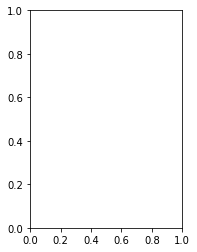

In [2]:
def CombineOrigins(df):
    df['origin'] = [x.split('_')[0] for x in df['origin']]
    return df

RATIO_VALUES = [
    ('F1_compute_mem_sum', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_compute_operation_count + 
     grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count),
    ('F2_coalesced_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_coalesced_memory_access_count /
                (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
    ('F3_local_global_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_local_memory_access_count /
            (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
    ('F4_compute_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_compute_operation_count /
                (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
]

for name, val in RATIO_VALUES:
    with db.Session() as s:
        df = pd.read_sql(
            s.query(val, grewe_features_db.OpenCLKernelWithRawGreweFeatures.origin).statement, s.bind)
    df = CombineOrigins(df)
    df.columns = [name, 'origin']
    df[f'log_{name}'] = np.log1p(df[name])
    benchmarks_only = df[df['origin'] == 'benchmarks']
    bins = np.linspace(min(df[name]), max(benchmarks_only[name]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    Distplot(x=name, group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(name)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{name}']), max(benchmarks_only[f'log_{name}']), 15)
    Distplot(x=f'log_{name}', group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(f'log_{name}')
    viz.Finalize(figsize=(10, 4))
    
    print(name)
    for group in sorted(set(df['origin'])):
        print(f'{group:16s}', SummarizeInts(df[df['origin'] == group][name]))
    print()

## Raw Feature Values

In [ ]:
RAW_FEATURE_COLUMNS = [
    'grewe_compute_operation_count',
    'grewe_global_memory_access_count',
    'grewe_local_memory_access_count',
    'grewe_coalesced_memory_access_count',
    'grewe_rational_operation_count',  # This feature was used in our extended feature set.
    # 'grewe_atomic_operation_count',  # This feature wasn't used at all.
]

for feature in RAW_FEATURE_COLUMNS:
    with db.Session() as s:
        df = pd.read_sql(
            s.query(getattr(grewe_features_db.OpenCLKernelWithRawGreweFeatures, feature),
                    grewe_features_db.OpenCLKernelWithRawGreweFeatures.origin).statement, s.bind)
    df = CombineOrigins(df)
    df[f'log_{feature}'] = np.log1p(df[feature])
    benchmarks_only = df[df['origin'] == 'benchmarks']
    bins = np.linspace(min(df[feature]), max(benchmarks_only[feature]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    Distplot(x=feature, group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(feature)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{feature}']), max(benchmarks_only[f'log_{feature}']), 15)
    Distplot(x=f'log_{feature}', group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(f'log_{feature}')
    viz.Finalize(figsize=(12, 4))
    
    print(feature)
    for group in sorted(set(df['origin'])):
        print(f'{group:16s}', SummarizeInts(df[df['origin'] == group][feature]))
    print()